In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

In [3]:
# load data
init_state = pd.read_csv('vn2_data/Week 0 - 2024-04-08 - Initial State.csv')
sales = pd.read_csv('vn2_data/Week 0 - 2024-04-08 - Sales.csv')
stock = pd.read_csv('vn2_data/Week 0 - In Stock.csv')

# print(sales.columns)
# print(df.head())

In [5]:

def csv_columns_to_tensor(col1, col2, input_filename, output_folder, output_filename):
    """
    Reads two columns from a CSV file and saves them as a PyTorch tensor with shape [rows, 1, 2].
    
    Parameters:
    col1: First column name to extract
    col2: Second column name to extract
    input_filename: Path to the input CSV file
    output_folder: Folder path where to save the tensor
    output_filename: Filename for the output tensor (without extension, .pt will be added)
    """
    # Read the CSV file
    df = pd.read_csv(input_filename)
    
    # Extract only the two specified columns
    data = df[[col1, col2]].values
    
    # Convert to tensor and reshape to [rows, 1, 2]
    tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(1)
    
    # Create folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Add .pt extension if not present
    if not output_filename.endswith('.pt'):
        output_filename = output_filename + '.pt'
    
    # Save tensor
    filepath = os.path.join(output_folder, output_filename)
    torch.save(tensor, filepath)
    
    print(f"Tensor saved to {filepath}")
    print(f"Tensor shape: {tensor.shape}")

# Usage example:
# REMEMBER TO CHECK THE COLUMN NAMES AGAIN AFTER WEEK 1!!!!!!
csv_columns_to_tensor('End Inventory', 'In Transit W+2', 
                      'vn2_data/Week 0 - 2024-04-08 - Initial State.csv', 
                      'vn2_processed_data/all_data', 
                      'inventory_state')

Tensor saved to vn2_processed_data/all_data/inventory_state.pt
Tensor shape: torch.Size([599, 1, 2])


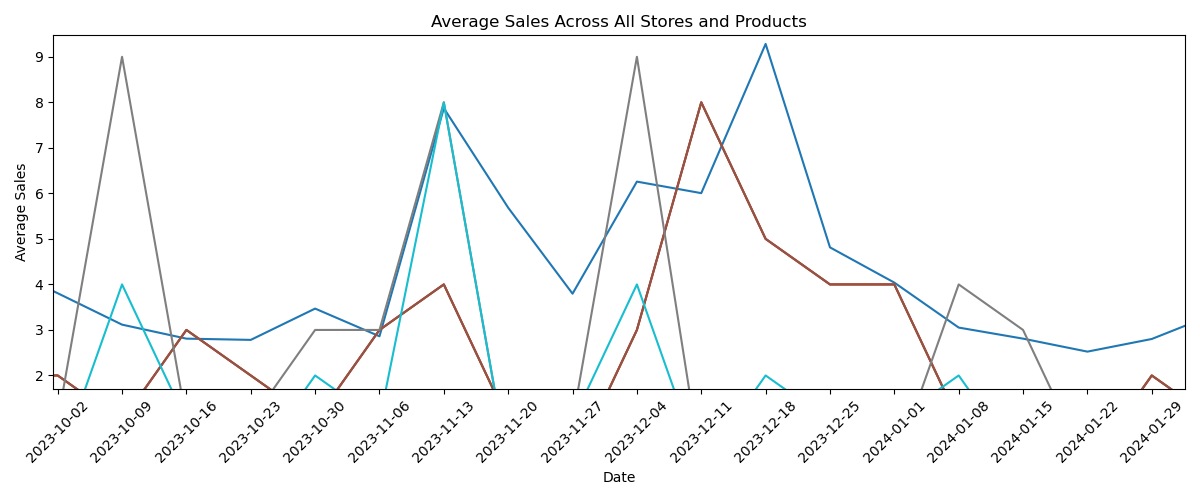

In [ ]:
# select the j-th row and make a time series plot of the sales
j = 307
plt.plot(sales.iloc[j, 2:].values)
plt.plot(stock.iloc[j, 2:].values)
plt.show()

# # select the j-th row and make a time series plot of the sales
# plt.plot(sales.iloc[j].values)
# plt.show()

In [8]:
# Get all columns except Store and Product
date_columns = stock.columns.difference(['Store', 'Product'])

# Calculate percentage of zeroes for each column
zero_percentages = (stock[date_columns] == 0).mean() * 100

# Print the results
print("Percentage of zeroes per column:")
print(zero_percentages)

# Or if you want summary statistics:
print(f"\nOverall statistics:")
print(f"Mean percentage of zeroes: {zero_percentages.mean():.2f}%")
print(f"Min percentage of zeroes: {zero_percentages.min():.2f}%")
print(f"Max percentage of zeroes: {zero_percentages.max():.2f}%")

Percentage of zeroes per column:
2021-04-12    34.891486
2021-04-19    30.717863
2021-04-26    28.213689
2021-05-03    28.881469
2021-05-10    31.218698
                ...    
2024-05-06     0.000000
2024-05-13     0.000000
2024-05-20     0.000000
2024-05-27     0.000000
2024-06-03     0.000000
Length: 165, dtype: float64

Overall statistics:
Mean percentage of zeroes: 10.64%
Min percentage of zeroes: 0.00%
Max percentage of zeroes: 34.89%


In [3]:
# Get all columns except Store and Product
date_columns = stock.columns.difference(['Store', 'Product'])

# Calculate percentage of stockouts (False values) for each column
stockout_percentages = (~stock[date_columns]).mean() * 100

# Print the results
print("Percentage of stockouts per column:")
print(stockout_percentages)

# Or if you want summary statistics:
print(f"\nOverall statistics:")
print(f"Mean percentage of stockouts: {stockout_percentages.mean():.2f}%")
print(f"Min percentage of stockouts: {stockout_percentages.min():.2f}%")
print(f"Max percentage of stockouts: {stockout_percentages.max():.2f}%")

Percentage of stockouts per column:
2021-04-12    34.891486
2021-04-19    30.717863
2021-04-26    28.213689
2021-05-03    28.881469
2021-05-10    31.218698
                ...    
2024-05-06     0.000000
2024-05-13     0.000000
2024-05-20     0.000000
2024-05-27     0.000000
2024-06-03     0.000000
Length: 165, dtype: float64

Overall statistics:
Mean percentage of stockouts: 10.64%
Min percentage of stockouts: 0.00%
Max percentage of stockouts: 34.89%


In [10]:
def print_rows_below_stockout_threshold(stock, threshold):
    """
    Prints the percentage of rows with at most 'threshold' percentage of stockouts.
    
    Parameters:
    stock: DataFrame with Store, Product columns and date columns with True/False values
    threshold: Maximum allowed percentage of stockouts (0-100)
    """
    # Get all columns except Store and Product
    date_columns = stock.columns.difference(['Store', 'Product'])
    
    # Calculate percentage of stockouts per row
    stockout_percentages_per_row = (~stock[date_columns]).mean(axis=1) * 100
    
    # Count rows with at most threshold% stockouts
    rows_below_threshold = (stockout_percentages_per_row <= threshold).sum()
    total_rows = len(stock)
    percentage = (rows_below_threshold / total_rows) * 100
    
    print(f"Percentage of rows with at most {threshold}% stockouts: {percentage:.2f}%")
    print(f"({rows_below_threshold} out of {total_rows} rows)")

# Usage example:
print_rows_below_stockout_threshold(stock, 10)  # rows with at most 10% stockouts

Percentage of rows with at most 10% stockouts: 67.28%
(403 out of 599 rows)


In [ ]:
def filter_by_stockout_threshold(stock, threshold, dfs):
    """
    Filters stock and other dataframes to keep only rows with at most threshold% stockouts.
    
    Parameters:
    stock: DataFrame with Store, Product columns and date columns with True/False values
    threshold: Maximum allowed percentage of stockouts (0-100)
    dfs: List of other DataFrames with the same number of rows as stock
    
    Returns:
    filtered_stock: Filtered version of stock
    filtered_dfs: List of filtered versions of the input dfs
    """
    # Get all columns except Store and Product
    date_columns = stock.columns.difference(['Store', 'Product'])
    
    # Calculate percentage of stockouts per row
    stockout_percentages_per_row = (~stock[date_columns]).mean(axis=1) * 100
    
    # Create mask for rows that meet the criteria
    mask = stockout_percentages_per_row <= threshold
    
    # Filter stock
    filtered_stock = stock[mask].reset_index(drop=True)
    
    # Filter all other dataframes
    filtered_dfs = [df[mask].reset_index(drop=True) for df in dfs]
    
    print(f"Kept {mask.sum()} out of {len(stock)} rows ({(mask.sum()/len(stock)*100):.2f}%)")
    
    return filtered_stock, filtered_dfs

# Usage example:
filtered_stock, [filtered_sales] = filter_by_stockout_threshold(stock, 10, [sales])

# Or with multiple dataframes:
# filtered_stock, [filtered_sales, filtered_other] = filter_by_stockout_threshold(stock, 10, [sales, other_df])

Kept 403 out of 599 rows (67.28%)


In [4]:
# make a histogram of the percentage of 0s in the filtered sales
plt.hist(filtered_sales.apply(lambda x: (x == 0).mean()), bins=20)
plt.show()


NameError: name 'filtered_sales' is not defined

In [20]:
import torch
import os

def df_to_tensor(df):
    """
    Converts a dataframe to a PyTorch tensor with shape [rows, 1, time].
    
    Parameters:
    df: DataFrame with Store, Product columns and date columns
    
    Returns:
    tensor: PyTorch tensor with shape [rows, 1, time]
    """
    # Get all date columns (exclude Store and Product)
    date_columns = df.columns.difference(['Store', 'Product'])
    
    # Sort date columns to ensure chronological order
    date_columns = sorted(date_columns)
    
    # Extract only the date columns as numpy array
    data = df[date_columns].values
    
    # Convert to tensor and reshape to [rows, 1, time]
    tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(1)
    
    return tensor


def save_df_as_tensor(df, folder, filename):
    """
    Saves a dataframe as a PyTorch tensor with shape [rows, 1, time].
    
    Parameters:
    df: DataFrame with Store, Product columns and date columns
    folder: Folder path where to save the tensor
    filename: Filename (without extension, .pt will be added)
    """
    # Create tensor from dataframe
    tensor = df_to_tensor(df)
    
    # Create folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)
    
    # Add .pt extension if not present
    if not filename.endswith('.pt'):
        filename = filename + '.pt'
    
    # Save tensor
    filepath = os.path.join(folder, filename)
    torch.save(tensor, filepath)
    
    print(f"Tensor saved to {filepath}")
    print(f"Tensor shape: {tensor.shape}")

def save_tensor(tensor, folder, filename):
    """
    Saves a PyTorch tensor to a file.
    
    Parameters:
    tensor: PyTorch tensor to save
    folder: Folder path where to save the tensor
    filename: Filename (without extension, .pt will be added)
    """
    # Create folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)
    
    # Add .pt extension if not present
    if not filename.endswith('.pt'):
        filename = filename + '.pt'
    
    # Save tensor
    filepath = os.path.join(folder, filename)
    torch.save(tensor, filepath)
    
    print(f"Tensor saved to {filepath}")
    print(f"Tensor shape: {tensor.shape}")

# Usage example:
# tensor = df_to_tensor(sales)  # Just create tensor
# save_df_as_tensor(sales, 'data/tensors', 'sales_tensor')  # Create and save

In [12]:
!conda install -c conda-forge ipympl -y

2 channel Terms of Service accepted
Retrieving notices: done

EnvironmentNotWritableError: The current user does not have write permissions to the target environment.
  environment location: /apps/anaconda3
  uid: 578118369
  gid: 578118369




(403, 159)
Store          55.655087
Product       119.230769
2021-04-12      2.543424
2021-04-19      2.344913
2021-04-26      3.501241
                 ...    
2024-03-11      2.759305
2024-03-18      2.657568
2024-03-25      2.560794
2024-04-01      2.965261
2024-04-08      2.965261
Length: 159, dtype: float64


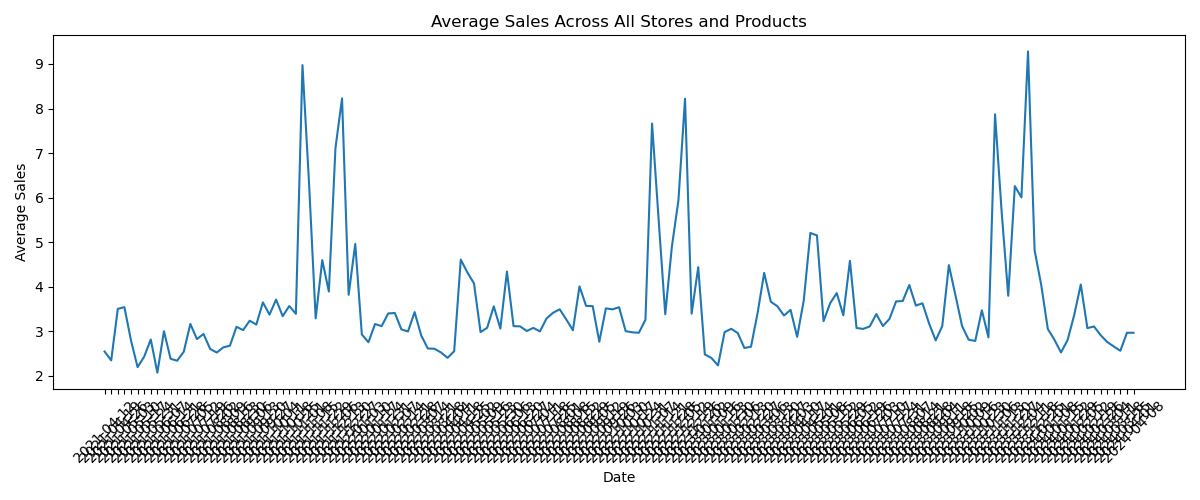

In [6]:
# Enable interactive plotting
%matplotlib widget

# print the number of rows and columns of the filtered sales
print(filtered_sales.shape)
# print the average of the sales across all columns (excluding Store and Product)
print(filtered_sales.mean())

# Get all date columns (exclude Store and Product)
date_columns = filtered_sales.columns.difference(['Store', 'Product'])
date_columns = sorted(date_columns)

# Extract sales data as numpy array
sales_data = filtered_sales[date_columns].values

# Plot the mean sales across all rows for each date
plt.figure(figsize=(12, 5))
plt.plot(date_columns, sales_data.mean(axis=0))
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.title('Average Sales Across All Stores and Products')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# print the mean of sales from period t to s
t = 104
s = 157
print(filtered_sales[date_columns].iloc[t:s].mean())

# print overall mean of sales considering these periods
print(filtered_sales[date_columns].iloc[t:s].mean().mean())


2021-04-12    4.283019
2021-04-19    3.264151
2021-04-26    4.566038
2021-05-03    6.056604
2021-05-10    4.188679
                ...   
2024-03-11    2.603774
2024-03-18    3.377358
2024-03-25    3.226415
2024-04-01    4.754717
2024-04-08    4.415094
Length: 157, dtype: float64
4.8668429275327485


In [ ]:
# Save all:
# save_df_as_tensor(stock, 'vn2_processed_data/all_data', 'stock')
# save_df_as_tensor(sales, 'vn2_processed_data/all_data', 'sales')  # .pt optional

# save filtered data
save_df_as_tensor(filtered_stock, 'vn2_processed_data/filtered_data', 'stock')
save_df_as_tensor(filtered_sales, 'vn2_processed_data/filtered_data', 'sales')


Tensor saved to vn2_processed_data/filtered_data/stock.pt
Tensor shape: torch.Size([403, 1, 165])
Tensor saved to vn2_processed_data/filtered_data/sales.pt
Tensor shape: torch.Size([403, 1, 157])


In [23]:
f_stock_tensor = df_to_tensor(filtered_stock)
f_stock_tensor_2copies = torch.stack([f_stock_tensor, f_stock_tensor])
print(f_stock_tensor_2copies.shape)

torch.Size([2, 403, 1, 165])


In [40]:
def create_date_features(df):
    """
    Creates a dataframe with date features from a sales dataframe.
    
    Parameters:
    df: DataFrame with date columns (excluding Store and Product)
    
    Returns:
    DataFrame with columns: date, day_of_week, month, year, day_of_month, days_from_christmas
    """
    # Get all date columns (exclude Store and Product)
    date_columns = df.columns.difference(['Store', 'Product'])
    date_columns = sorted(date_columns)
    
    # Convert to datetime
    dates = pd.to_datetime(date_columns)
    
    # Create the features dataframe
    date_features = pd.DataFrame({
        'date': dates,
        'day_of_week': dates.dayofweek,  # Monday=0, Sunday=6
        'month': dates.month,
        'year': dates.year,
        'day_of_month': dates.day
    })
    
    # Calculate days_from_christmas
    def calculate_days_from_christmas(date):
        # Christmas of the same year
        christmas_current = pd.Timestamp(year=date.year, month=12, day=25)
        # Christmas of previous year
        christmas_prev = pd.Timestamp(year=date.year - 1, month=12, day=25)
        # Christmas of next year
        christmas_next = pd.Timestamp(year=date.year + 1, month=12, day=25)
        
        # Calculate days from each Christmas
        days_from_current = (date - christmas_current).days
        days_from_prev = (date - christmas_prev).days
        days_from_next = (date - christmas_next).days
        
        # Return the one with minimum absolute value
        candidates = [days_from_current, days_from_prev, days_from_next]
        return min(candidates, key=abs)
    
    date_features['days_from_christmas'] = date_features['date'].apply(calculate_days_from_christmas)
    
    return date_features

# Usage example:
date_df = create_date_features(sales)
print(date_df.head())

        date  day_of_week  month  year  day_of_month  days_from_christmas
0 2021-04-12            0      4  2021            12                  108
1 2021-04-19            0      4  2021            19                  115
2 2021-04-26            0      4  2021            26                  122
3 2021-05-03            0      5  2021             3                  129
4 2021-05-10            0      5  2021            10                  136


In [41]:

def save_df_to_csv(df, folder, filename):
    """
    Saves a dataframe to CSV file.
    
    Parameters:
    df: DataFrame to save
    folder: Folder path where to save the CSV
    filename: Filename (without extension, .csv will be added)
    """
    # Create folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)
    
    # Add .csv extension if not present
    if not filename.endswith('.csv'):
        filename = filename + '.csv'
    
    # Create full filepath
    filepath = os.path.join(folder, filename)
    
    # Save to CSV without index
    df.to_csv(filepath, index=False)
    
    print(f"DataFrame saved to {filepath}")
    print(f"Shape: {df.shape}")

# Usage example:
save_df_to_csv(date_df, 'vn2_processed_data', 'date_features')

DataFrame saved to vn2_processed_data/date_features.csv
Shape: (157, 6)


In [27]:
# open 'data_files/favorita/weekly_sales.pt'
demand = torch.load('data_files/favorita/weekly_sales.pt')
# open 'data_files/favorita/dates_with_info.csv'
info = pd.read_csv('data_files/favorita/dates_with_info.csv')



In [28]:
print(demand.shape)
print(info.head())

torch.Size([33945, 1, 240])
         date  day_of_week  month  year  day_of_month  days_from_christmas  \
0  2013-01-01            2      1  2013             1                    7   
1  2013-01-08            2      1  2013             8                   14   
2  2013-01-15            2      1  2013            15                   21   
3  2013-01-22            2      1  2013            22                   28   
4  2013-01-29            2      1  2013            29                   35   

   christmas  earthquake  
0          0           0  
1          0           0  
2          0           0  
3          0           0  
4          0           0  
